In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, median_absolute_error

C:\Users\User\AppData\Roaming\Python\Python38\site-packages\pandas\core\computation\expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


Загружаем файл.

In [2]:
df = pd.read_csv('coin_Bitcoin.csv')
df

,SNo,Name,Symbol,Date,High,Low,Open,Close,Volume,Marketcap
0,1,Bitcoin,BTC,2013-04-29 23:59:59,147.488007,134.000000,134.444000,144.539993,0.000000e+00,1.603769e+09
1,2,Bitcoin,BTC,2013-04-30 23:59:59,146.929993,134.050003,144.000000,139.000000,0.000000e+00,1.542813e+09
2,3,Bitcoin,BTC,2013-05-01 23:59:59,139.889999,107.720001,139.000000,116.989998,0.000000e+00,1.298955e+09
3,4,Bitcoin,BTC,2013-05-02 23:59:59,125.599998,92.281898,116.379997,105.209999,0.000000e+00,1.168517e+09
4,5,Bitcoin,BTC,2013-05-03 23:59:59,108.127998,79.099998,106.250000,97.750000,0.000000e+00,1.085995e+09
...,...,...,...,...,...,...,...,...,...,...
2986,2987,Bitcoin,BTC,2021-07-02 23:59:59,33939.588699,32770.680780,33549.600177,33897.048590,3.872897e+10,6.354508e+11
2987,2988,Bitcoin,BTC,2021-07-03 23:59:59,34909.259899,33402.696536,33854.421362,34668.548402,2.438396e+10,6.499397e+11
2988,2989,Bitcoin,BTC,2021-07-04 23:59:59,35937.567147,34396.477458,34665.564866,35287.779766,2.492431e+10,6.615748e+11
2989,2990,Bitcoin,BTC,2021-07-05 23:59:59,35284.344430,33213.661034,35284.344430,33746.002456,2.672155e+10,6.326962e+11


Как видим, в датасете достаточное количество информации. Судя по тому, как менялся marketcap - Биткоин всё сильнее забирает рынок.

In [3]:
df = df.drop(columns='SNo')
df

,Name,Symbol,Date,High,Low,Open,Close,Volume,Marketcap
0,Bitcoin,BTC,2013-04-29 23:59:59,147.488007,134.000000,134.444000,144.539993,0.000000e+00,1.603769e+09
1,Bitcoin,BTC,2013-04-30 23:59:59,146.929993,134.050003,144.000000,139.000000,0.000000e+00,1.542813e+09
2,Bitcoin,BTC,2013-05-01 23:59:59,139.889999,107.720001,139.000000,116.989998,0.000000e+00,1.298955e+09
3,Bitcoin,BTC,2013-05-02 23:59:59,125.599998,92.281898,116.379997,105.209999,0.000000e+00,1.168517e+09
4,Bitcoin,BTC,2013-05-03 23:59:59,108.127998,79.099998,106.250000,97.750000,0.000000e+00,1.085995e+09
...,...,...,...,...,...,...,...,...,...
2986,Bitcoin,BTC,2021-07-02 23:59:59,33939.588699,32770.680780,33549.600177,33897.048590,3.872897e+10,6.354508e+11
2987,Bitcoin,BTC,2021-07-03 23:59:59,34909.259899,33402.696536,33854.421362,34668.548402,2.438396e+10,6.499397e+11
2988,Bitcoin,BTC,2021-07-04 23:59:59,35937.567147,34396.477458,34665.564866,35287.779766,2.492431e+10,6.615748e+11
2989,Bitcoin,BTC,2021-07-05 23:59:59,35284.344430,33213.661034,35284.344430,33746.002456,2.672155e+10,6.326962e+11


Заранее выбрасываем одну лишнюю колонку, чтобы она не портила матрицу коррелляции.

In [4]:
df.describe()

,High,Low,Open,Close,Volume,Marketcap
count,2991.000000,2991.000000,2991.000000,2991.000000,2.991000e+03,2.991000e+03
mean,6893.326038,6486.009539,6700.146240,6711.290443,1.090633e+10,1.208761e+11
std,11642.832456,10869.032130,11288.043736,11298.141921,1.888895e+10,2.109438e+11
min,74.561096,65.526001,68.504997,68.431000,0.000000e+00,7.784112e+08
25%,436.179001,422.879486,430.445496,430.569489,3.036725e+07,6.305579e+09
50%,2387.610107,2178.500000,2269.889893,2286.409912,9.460360e+08,3.741503e+10
75%,8733.926948,8289.800459,8569.656494,8576.238715,1.592015e+10,1.499957e+11
max,64863.098908,62208.964366,63523.754869,63503.457930,3.509679e+11,1.186364e+12


Описательная статистика датасета. Видим. что значительную разницы между значениями между 2 и 3 квартилем, и огромную между 3 и максимальным значением. Обычно такие выбросы очищаются, но, так как мы работаем с криптовалютой (логика та же, что и с акциями), то удалять такие значения не имеет смысла, нам важно видеть все скачки цены.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2991 entries, 0 to 2990
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Name       2991 non-null   object 
 1   Symbol     2991 non-null   object 
 2   Date       2991 non-null   object 
 3   High       2991 non-null   float64
 4   Low        2991 non-null   float64
 5   Open       2991 non-null   float64
 6   Close      2991 non-null   float64
 7   Volume     2991 non-null   float64
 8   Marketcap  2991 non-null   float64
dtypes: float64(6), object(3)
memory usage: 210.4+ KB


С типами проблем нет.

In [6]:
df.isna().sum()

Name         0
Symbol       0
Date         0
High         0
Low          0
Open         0
Close        0
Volume       0
Marketcap    0
dtype: int64

Пропущенных значений нет.

<Axes: xlabel='Date', ylabel='Close'>

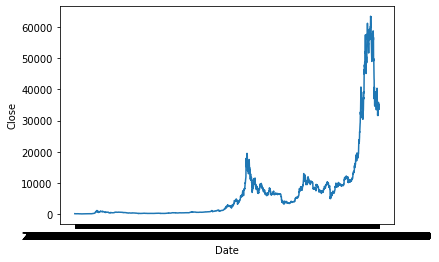

In [7]:
sns.lineplot(data=df, x=df.Date, y=df.Close, sizes=(80,60))

График изменения цены.

<ipython-input-8-215c75a5c9aa>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  plt.matshow(df.corr(), fignum=f.number)


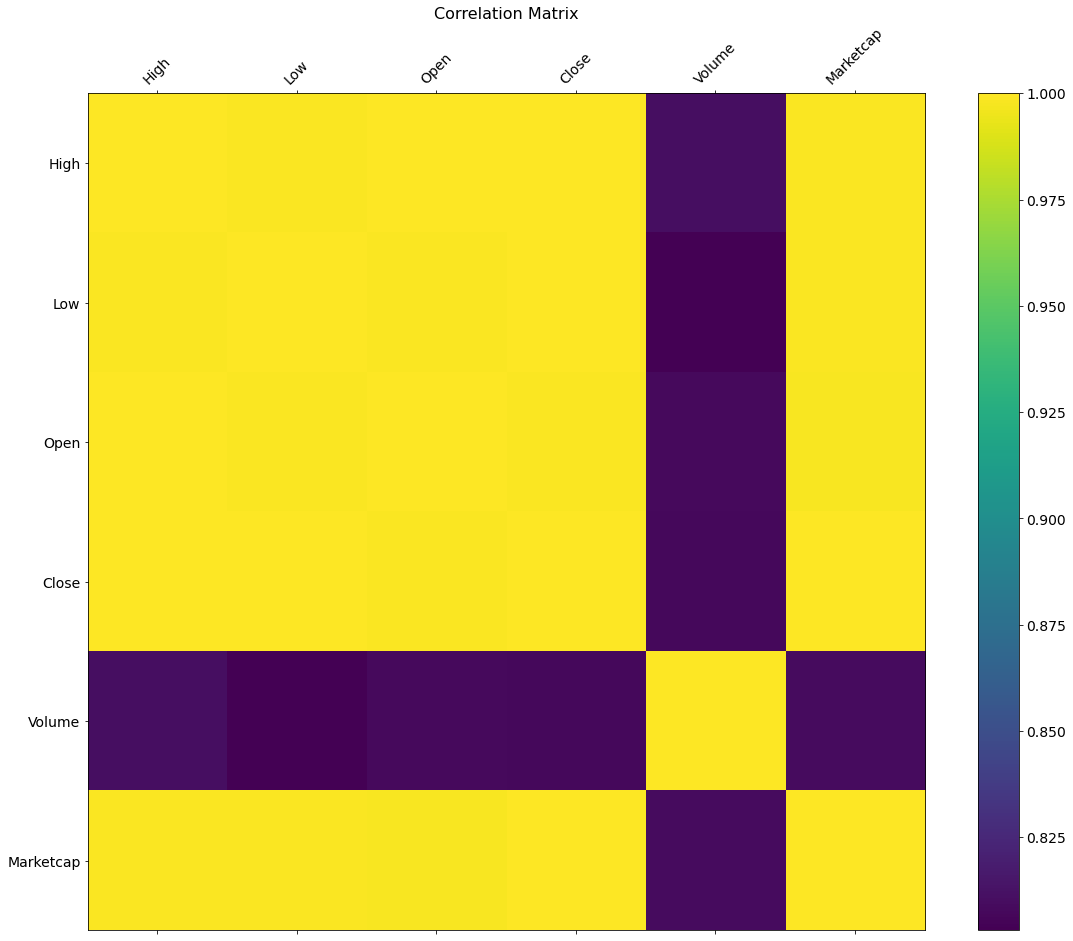

In [8]:
f = plt.figure(figsize=(19, 15))
plt.matshow(df.corr(), fignum=f.number)
plt.xticks(range(df.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns, fontsize=14, rotation=45)
plt.yticks(range(df.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16);

Видим насколько зависят друг от друга столбцы датасета.

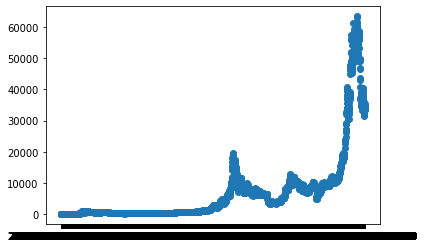

In [9]:
plt.scatter(x=df['Date'],y=df['Close'])


<Axes: xlabel='Volume', ylabel='Density'>

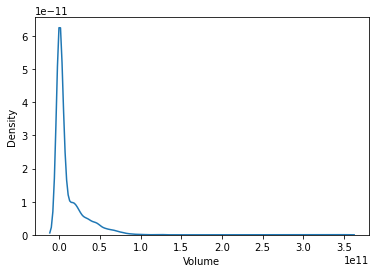

In [10]:
sns.kdeplot(df['Volume'])

График распределения наблюдений в наборе данных. Как видим, большинство значений стремится к нулю. Проверим на гистограмме.

<Axes: xlabel='Volume', ylabel='Count'>

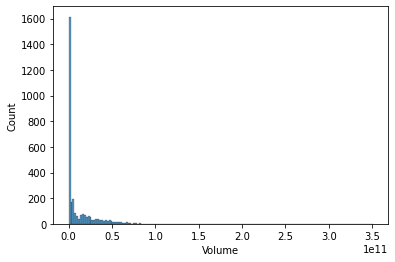

In [11]:
sns.histplot(df['Volume'])

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Задаем гиперпараметры модели
input_size = 1
hidden_size = 32
num_layers = 2
output_size = 1
seq_length = 30 # длина входной последовательности (количество дней для предсказания)

# Создаем LSTM модель
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)

        out, (h_n, c_n) = self.lstm(x, (h0, c0))

        out = self.fc(out[:, -1, :])

        return out


close_prices = df['Close'].values.reshape(-1, 1)

# Нормализуем данные
scaler = MinMaxScaler()
close_prices = scaler.fit_transform(close_prices)

df = df.drop(columns=['Name', 'Symbol', 'High', 'Low', 'Open', 'Volume', 'Marketcap'])

# Создаем входные и выходные последовательности
x = []
y = []
for i in range(len(close_prices) - seq_length - 1):
    _x = close_prices[i:(i+seq_length)]
    _y = close_prices[i+seq_length]
    x.append(_x)
    y.append(_y)
x = np.array(x)
y = np.array(y)

# Разбиваем данные на тренировочную и тестовую выборки
train_size = int(len(x) * 0.7)
test_size = len(x) - train_size
train_x, test_x = torch.from_numpy(x[0:train_size,:,:]).type(torch.Tensor), torch.from_numpy(x[train_size:len(x),:,:]).type(torch.Tensor)
train_y, test_y = torch.from_numpy(y[0:train_size,:]).type(torch.Tensor), torch.from_numpy(y[train_size:len(y),:]).type(torch.Tensor)


Делаем обёрточный класс, чтобы можно было использовать GridSearchCV

In [13]:
from sklearn.base import BaseEstimator, RegressorMixin
class LSTMWrapper(BaseEstimator, RegressorMixin):
    def __init__(self, input_size=1, hidden_size=32, num_layers=2, output_size=1, learning_rate=0.001):
        self.model = LSTM(input_size, hidden_size, num_layers, output_size)
        self.loss_fn = nn.MSELoss()
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=learning_rate)

    def fit(self, X, y):
        X = X.to(device)
        y = y.to(device)
        self.model.train()
        for epoch in range(100):
            self.optimizer.zero_grad()
            output = self.model(X)
            loss = self.loss_fn(output, y)
            loss.backward()
            self.optimizer.step()

    def predict(self, X):
        self.model.eval()
        with torch.no_grad():
            X = X.to(device)
            output = self.model(X)
            return output.cpu().numpy()

    def score(self, X, y):
        X = X.to(device)
        y = y.to(device)
        output = self.predict(X)
        loss = self.loss_fn(torch.Tensor(output), y)
        return -loss.item()

    def get_params(self, deep=True):
        return {'input_size': self.model.lstm.input_size,
                'hidden_size': self.model.lstm.hidden_size,
                'num_layers': self.model.lstm.num_layers,
                'output_size': self.model.fc.out_features,
                'learning_rate': self.optimizer.param_groups[0]['lr']}

    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.learning_rate)
        return self


In [14]:
input_size = 1
hidden_size = 32
num_layers = 2
output_size = 1
seq_length = 30

# Создаем экземпляр модели
model = LSTMWrapper(input_size, hidden_size, num_layers, output_size)

# Задаем значения параметров для поиска
params = {'learning_rate': [0.001, 0.01, 0.1]}

# Создаем экземпляр GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=params, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# Обучаем модель с помощью GridSearchCV
grid_search.fit(train_x, train_y)

# Выводим лучшее значение скорости обучения
print('Лучшее значение скорости обучения: ', grid_search.best_params_)


Лучшее значение скорости обучения:  {'learning_rate': 0.01}


In [15]:
params = {'learning_rate': [0.01,0.011,0.013, 0.015, 0.017, 0.02,0.03]}

# Создаем экземпляр GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=params, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# Обучаем модель с помощью GridSearchCV
grid_search.fit(train_x, train_y)

# Выводим лучшее значение скорости обучения
print('Лучшее значение скорости обучения: ', grid_search.best_params_)
print(grid_search.best_params_['learning_rate'])

Лучшее значение скорости обучения:  {'learning_rate': 0.015}
0.015


In [16]:
res = grid_search.best_params_['learning_rate']
res

0.015

Epoch: 0, loss: 0.01733
Epoch: 10, loss: 0.00485
Epoch: 20, loss: 0.00316
Epoch: 30, loss: 0.00269
Epoch: 40, loss: 0.00222
Epoch: 50, loss: 0.00012
Epoch: 60, loss: 0.00021
Epoch: 70, loss: 0.00007
Epoch: 80, loss: 0.00006
Epoch: 90, loss: 0.00005
Epoch: 100, loss: 0.00004
Epoch: 150, loss: 0.00004
Epoch: 200, loss: 0.00003
Epoch: 250, loss: 0.00003
Epoch: 300, loss: 0.00002
Epoch: 350, loss: 0.00002
Epoch: 400, loss: 0.00002
Epoch: 450, loss: 0.00002
Epoch: 500, loss: 0.00002
Epoch: 550, loss: 0.00002
Epoch: 600, loss: 0.00002
Epoch: 650, loss: 0.00002


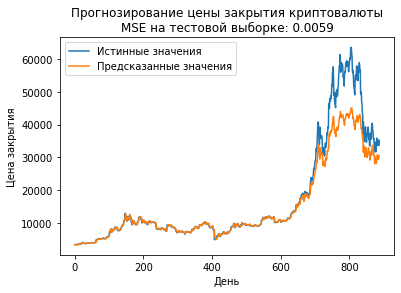

Wall time: 1min 42s


In [17]:
%%time
# Обучаем модель

model = LSTM(input_size, hidden_size, num_layers, output_size).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=res)

for epoch in range(700):
    optimizer.zero_grad()
    outputs = model(train_x.to(device))
    loss = criterion(outputs, train_y.to(device))
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        if epoch<100: 
            print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))
        else: 
            if epoch % 50 == 0: 
                print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

# Предсказываем значения на тестовой выборке
model.eval()
test_predict = model(test_x.to(device))

# Вычисляем ошибку на тестовой выборке
test_loss = criterion(test_predict, test_y.to(device))

# Визуализируем результаты
test_predict = test_predict.cpu().detach().numpy()
test_y = test_y.cpu().detach().numpy()

test_predict = scaler.inverse_transform(test_predict)
test_y = scaler.inverse_transform(test_y)

plt.plot(test_y, label='Истинные значения')
plt.plot(test_predict, label='Предсказанные значения')
plt.xlabel('День')
plt.ylabel('Цена закрытия')
plt.title('Прогнозирование цены закрытия криптовалюты\nMSE на тестовой выборке: {:.4f}'.format(test_loss))
plt.legend()
plt.show()

Как мы можем увидить, ошибка минимальная, а на графике предсказанные значения почти полностью дублируют истинные значения. Считаю, что модель полность справилась с поставленной задачей, так как полное повторение на нестабильном графике с элементами быстрого роста невозможно.
Исходя из этого делаем вывод, что модель улучшения не требует, так как сильно заметного результата это не даст, хотя при этом потребует значительного количества ресурсов, а это не выгодно.

Теперь попробуем протестировать другие модели и сравнить.

In [18]:
def regr_metrics(test_x, test_y, y_pred, model):
    print('R^2 score:', model.score(test_x.squeeze(), test_y))
    print('mean_absolute_error', mean_absolute_error(test_y, y_pred))
    print('median_absolute_error', median_absolute_error(test_y, y_pred))
    mseloss = mean_squared_error(test_y, y_pred)
    return mseloss

In [19]:
#train_x, test_x train_y, test_y

model = LinearRegression()

# обучение модели

model.fit(train_x.numpy().squeeze(), train_y.numpy())

# прогнозирование цены для тестового набора
y_pred = model.predict(test_x.squeeze())

# оценка точности модели

mseloss = regr_metrics(test_x, test_y, y_pred, model)

R^2 score: -1.1662650424477423
mean_absolute_error 17051.158
median_absolute_error 9798.138


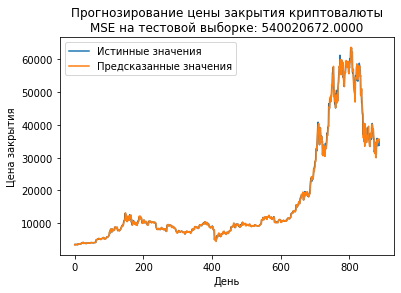

In [20]:
y_pred = scaler.inverse_transform(y_pred)
plt.plot(test_y, label='Истинные значения')
plt.plot(y_pred, label='Предсказанные значения')
plt.xlabel('День')
plt.ylabel('Цена закрытия')
plt.title('Прогнозирование цены закрытия криптовалюты\nMSE на тестовой выборке: {:.4f}'.format(mseloss))
plt.legend()
plt.show()

Как видим, линейная регрессия с такой задачей не справляется. Ожидаемо, так как эта модель слишком простая для таких данных и не может нормально обучиться. (синюю полоску даже не видно)

In [21]:
regr = RandomForestRegressor(max_depth=2, random_state=0)
regr.fit(train_x.numpy().squeeze(), train_y.numpy())
y_pred = regr.predict(test_x.squeeze())
mseloss = regr_metrics(test_x, test_y, y_pred, regr)

<ipython-input-21-dbdcf1f600f1>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  regr.fit(train_x.numpy().squeeze(), train_y.numpy())


R^2 score: -1.166307258818382
mean_absolute_error 17051.271174595397
median_absolute_error 9798.175227994201


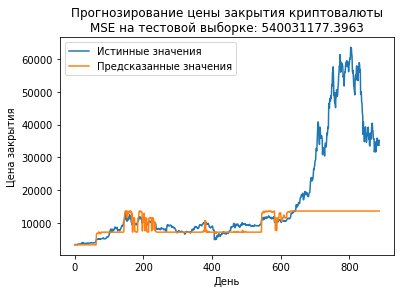

In [22]:
y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1))
plt.plot(test_y, label='Истинные значения')
plt.plot(y_pred, label='Предсказанные значения')
plt.xlabel('День')
plt.ylabel('Цена закрытия')
plt.title('Прогнозирование цены закрытия криптовалюты\nMSE на тестовой выборке: {:.4f}'.format(mseloss))
plt.legend()
plt.show()

Случайный лес показал ужасный результат, пусть и лучше чем линейная регрессия. То, что он потеряется на моменты быстрого роста было ожидаемо, но и его неудачные попытки предсказания на достаточно стабильном участке графика, показывают что для таких задач он не подходит.

In [23]:
reg = GradientBoostingRegressor(random_state=0)
reg.fit(train_x.squeeze(), train_y)
y_pred = reg.predict(test_x.squeeze())
reg.score(test_x.squeeze(), test_y)
mseloss = regr_metrics(test_x, test_y, y_pred, reg)

F:\Anaconda\lib\site-packages\sklearn\ensemble\_gb.py:570: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


R^2 score: -1.1663023977393698
mean_absolute_error 17051.25320102326
median_absolute_error 9798.138292510004


Как видим, метрики ужасные. При этом, у всех трёх моделей, они примерно одинаковые, хотя у градиентного бустинга ситуация немного лучше, пусть и не сильно.

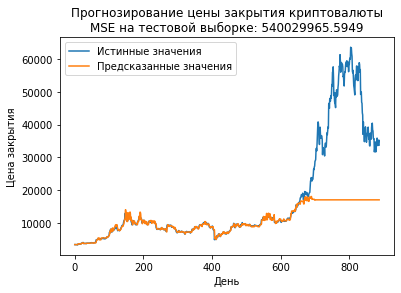

In [24]:
y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1))

plt.plot(test_y, label='Истинные значения')
plt.plot(y_pred, label='Предсказанные значения')
plt.xlabel('День')
plt.ylabel('Цена закрытия')
plt.title('Прогнозирование цены закрытия криптовалюты\nMSE на тестовой выборке: {:.4f}'.format(mseloss))
plt.legend()
plt.show()

Как видим, градиентный бустинг неплохо справляется со стабильными временными рядами, но как только дело доходит до серьёзных колебаний и стремительного роста - начинает теряться и просто ровно идёт. Тоже не подходит для решения таких задач.

In [29]:
reg = GradientBoostingRegressor(random_state=0, n_estimators=220,
          max_depth=16,
          criterion='squared_error',
          learning_rate=0.03,
          min_samples_leaf=16,
          min_samples_split=16)
reg.fit(train_x.squeeze(), train_y)
y_pred = reg.predict(test_x.squeeze())
reg.score(test_x.squeeze(), test_y)
mseloss = regr_metrics(test_x, test_y, y_pred, reg)

F:\Anaconda\lib\site-packages\sklearn\ensemble\_gb.py:570: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


R^2 score: -1.16630400165496
mean_absolute_error 17051.258630708307
median_absolute_error 9798.139789604618


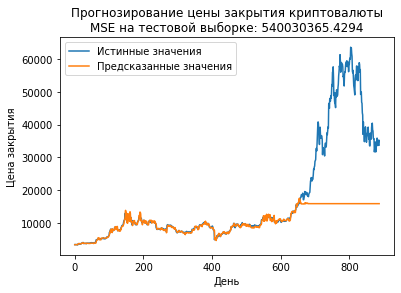

In [30]:
y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1))

plt.plot(test_y, label='Истинные значения')
plt.plot(y_pred, label='Предсказанные значения')
plt.xlabel('День')
plt.ylabel('Цена закрытия')
plt.title('Прогнозирование цены закрытия криптовалюты\nMSE на тестовой выборке: {:.4f}'.format(mseloss))
plt.legend()
plt.show()

Как видим, улучшить градиентный бустинг тоже можно. Получилось лучше залезть на пик, при этом стабильную часть графика он прошел точнее. И всё же это не уровень нейросети.

Таким образом, LSTM нейронная сеть оказалась наиболее эффективным вариантом из всех. Да, она не в состоянии идентично повторять настоящие значения на пиковых моментах, но чем стабильнее график, тем меньше отклонений показывает нейронная сеть. LSTM отлично подходит для решения задач связанных с обработкой временных рядов.